# RFM客户消费行为评分模型（案例）

### 材料提供者张薇
### 数据来源CSDN

## 一. 数据准备

In [71]:
# 导入包
import pandas as pd
import numpy as np
import os
from matplotlib import rcParams
from matplotlib.cm import rainbow
import seaborn as sns  
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['SimHei']#用来正常显示中文标签
%matplotlib inline

In [8]:
df = pd.read_excel("PYTHON-RFM实战数据.xlsx")

In [9]:
df.head()

,品牌名称,买家昵称,付款日期,订单状态,实付金额,邮费,省份,城市,购买数量
0,数据不吹牛,叫我李2,2019-01-01 00:17:59,交易成功,186,6,上海,上海市,1
1,数据不吹牛,0cyb1992,2019-01-01 00:59:54,交易成功,145,0,广东省,广州市,1
2,数据不吹牛,萝污萌莉,2019-01-01 07:48:48,交易成功,194,8,山东省,东营市,1
3,数据不吹牛,atblovemyy,2019-01-01 09:15:49,付款以后用户退款成功，交易自动关闭,84,0,江苏省,镇江市,1
4,数据不吹牛,小星期鱼,2019-01-01 09:59:33,付款以后用户退款成功，交易自动关闭,74,0,上海,上海市,1


In [10]:
df['订单状态'].unique()

array(['交易成功', '付款以后用户退款成功，交易自动关闭'], dtype=object)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28833 entries, 0 to 28832
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   品牌名称    28833 non-null  object        
 1   买家昵称    28833 non-null  object        
 2   付款日期    28833 non-null  datetime64[ns]
 3   订单状态    28833 non-null  object        
 4   实付金额    28833 non-null  int64         
 5   邮费      28833 non-null  int64         
 6   省份      28833 non-null  object        
 7   城市      28832 non-null  object        
 8   购买数量    28833 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 2.0+ MB


In [12]:
"""数据清洗"""
#提出退款
df = df.loc[df['订单状态'] == '交易成功',:]
print('剔除退款后还剩:%d行' % len(df))

剔除退款后还剩:27793行


In [13]:
#关键字提取
df = df[['买家昵称','付款日期','实付金额']]
df.head()

,买家昵称,付款日期,实付金额
0,叫我李2,2019-01-01 00:17:59,186
1,0cyb1992,2019-01-01 00:59:54,145
2,萝污萌莉,2019-01-01 07:48:48,194
5,重碎叠,2019-01-01 10:00:07,197
6,iho_jann,2019-01-01 10:00:08,168


## 二.R F M模型

### 1.RMF值计算

In [15]:
#R值构造
r = df.groupby('买家昵称')['付款日期'].max().reset_index()
r.head()

,买家昵称,付款日期
0,.blue_ram,2019-02-04 17:49:34.000
1,.christiny,2019-01-29 14:17:15.000
2,.willn1,2019-01-11 03:46:18.000
3,.托托m,2019-01-11 02:26:33.000
4,0000妮,2019-06-28 16:53:26.458


In [16]:
r['R'] = (pd.to_datetime('2019-7-1') - r['付款日期']).dt.days
r = r[['买家昵称','R']]
r.head()

,买家昵称,R
0,.blue_ram,146
1,.christiny,152
2,.willn1,170
3,.托托m,170
4,0000妮,2


In [17]:
#F值构造
#引入日期标签辅助列
df['日期标签'] = df['付款日期'].astype(str).str[:10]

#把单个用户一天内订单合并
dup_f = df.groupby(['买家昵称','日期标签'])['付款日期'].count().reset_index()

#对合并后的用户统计频次
f = dup_f.groupby('买家昵称')['付款日期'].count().reset_index()
f.columns = ['买家昵称','F']
f.head()

,买家昵称,F
0,.blue_ram,1
1,.christiny,1
2,.willn1,1
3,.托托m,1
4,0000妮,1


In [18]:
#m值构造
sum_m = df.groupby('买家昵称')['实付金额'].sum().reset_index()
sum_m.columns = ['买家昵称','总支付金额']
com_m = pd.merge(sum_m,f,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')

#计算用户平均支付金额
com_m['M'] = com_m['总支付金额'] / com_m['F']
com_m.head()

,买家昵称,总支付金额,F,M
0,.blue_ram,49,1,49.0
1,.christiny,183,1,183.0
2,.willn1,34,1,34.0
3,.托托m,37,1,37.0
4,0000妮,164,1,164.0


In [19]:
#3值合并
rfm = pd.merge(r,com_m,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')
rfm = rfm[['买家昵称','R','F','M']]
rfm.head()

,买家昵称,R,F,M
0,.blue_ram,146,1,49.0
1,.christiny,152,1,183.0
2,.willn1,170,1,34.0
3,.托托m,170,1,37.0
4,0000妮,2,1,164.0


### 2. 按R F M值打分(人为设置客户分层条件）

In [20]:
rfm['R-SCORE'] = pd.cut(rfm['R'],bins = [0,30,60,90,120,1000000],labels = [5,4,3,2,1],right = False).astype(float)
rfm.head()

,买家昵称,R,F,M,R-SCORE
0,.blue_ram,146,1,49.0,1.0
1,.christiny,152,1,183.0,1.0
2,.willn1,170,1,34.0,1.0
3,.托托m,170,1,37.0,1.0
4,0000妮,2,1,164.0,5.0


In [21]:
rfm['F-SCORE'] = pd.cut(rfm['F'],bins = [1,2,3,4,5,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm['M-SCORE'] = pd.cut(rfm['M'],bins = [0,50,100,150,200,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE
0,.blue_ram,146,1,49.0,1.0,1.0,1.0
1,.christiny,152,1,183.0,1.0,1.0,4.0
2,.willn1,170,1,34.0,1.0,1.0,1.0
3,.托托m,170,1,37.0,1.0,1.0,1.0
4,0000妮,2,1,164.0,5.0,1.0,4.0


In [22]:
rfm['R是否大于均值'] = (rfm['R-SCORE'] > rfm['R-SCORE'].mean()) * 1
rfm['F是否大于均值'] = (rfm['F-SCORE'] > rfm['F-SCORE'].mean()) * 1
rfm['M是否大于均值'] = (rfm['M-SCORE'] > rfm['M-SCORE'].mean()) * 1
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1


In [23]:
rfm['人群数值'] = (rfm['R是否大于均值']*100)  + (rfm['F是否大于均值']*10) + (rfm['M是否大于均值']*1)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0,0
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1,1
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0,0
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0,0
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1,101


In [24]:
#判断R/F/M是否大于均值
def transform_label(x):
    if x == 111:
        label = '重要价值客户'
    elif x == 110:
        label = '一般价值客户'
    elif x == 101:
        label = '重要发展用户'
    elif x == 100:
        label = '一般发展用户'
    elif x == 11:
        label = '重要保持客户'
    elif x == 10:
        label = '一般保持客户'
    elif x == 1:
        label = '重要挽留客户'
    elif x == 0:
        label = '一般挽留客户'
    return label

In [25]:
rfm['人群类型'] = rfm['人群数值'].apply(transform_label)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值,人群类型
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0,0,一般挽留客户
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1,1,重要挽留客户
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0,0,一般挽留客户
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0,0,一般挽留客户
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1,101,重要发展用户


In [64]:
rfm.to_csv('rfm_1.csv')

In [26]:
count = rfm['人群类型'].value_counts().reset_index()
count.columns = ['客户类型','人数']
count['人数占比'] = count['人数'] / count['人数'].sum()
count

,客户类型,人数,人数占比
0,重要挽留客户,7338,0.288670
1,一般挽留客户,6680,0.262785
2,重要发展用户,5427,0.213493
3,一般发展用户,4224,0.166168
4,重要价值客户,756,0.029740
5,一般价值客户,450,0.017703
6,重要保持客户,360,0.014162
7,一般保持客户,185,0.007278


In [27]:
rfm['购买总金额'] = rfm['F'] * rfm['M']
mon = rfm.groupby('人群类型')['购买总金额'].sum().reset_index()
mon.columns = ['客户类型','消费金额']
mon['金额占比'] = mon['消费金额'] / mon['消费金额'].sum()
mon

,客户类型,消费金额,金额占比
0,一般价值客户,64075.0,0.018248
1,一般保持客户,25803.0,0.007349
2,一般发展用户,270869.0,0.077142
3,一般挽留客户,444617.0,0.126624
4,重要价值客户,269230.0,0.076675
5,重要保持客户,116665.0,0.033226
6,重要发展用户,981893.0,0.279638
7,重要挽留客户,1338153.0,0.381098


In [28]:
result = pd.merge(count,mon,left_on = '客户类型',right_on = '客户类型')
result

,客户类型,人数,人数占比,消费金额,金额占比
0,重要挽留客户,7338,0.288670,1338153.0,0.381098
1,一般挽留客户,6680,0.262785,444617.0,0.126624
2,重要发展用户,5427,0.213493,981893.0,0.279638
3,一般发展用户,4224,0.166168,270869.0,0.077142
4,重要价值客户,756,0.029740,269230.0,0.076675
5,一般价值客户,450,0.017703,64075.0,0.018248
6,重要保持客户,360,0.014162,116665.0,0.033226
7,一般保持客户,185,0.007278,25803.0,0.007349


In [29]:
result.to_csv('sales_rfm_fina.csv')

### 3.K-Means聚类

In [58]:
data_1 = rfm
cdata = data_1.drop(['买家昵称','R-SCORE','F-SCORE','M-SCORE','R是否大于均值','F是否大于均值','M是否大于均值','人群数值','人群类型','购买总金额'],1)
cdata

,R,F,M
0,146,1,49.0
1,152,1,183.0
2,170,1,34.0
3,170,1,37.0
4,2,1,164.0
...,...,...,...
25415,84,1,175.0
25416,72,1,87.0
25417,11,2,248.5
25418,24,1,137.0


In [59]:
zcdata=(cdata-cdata.mean())/cdata.std()
zcdata.head()

,R,F,M
0,0.836250,-0.255847,-1.043555
1,0.938901,-0.255847,0.722944
2,1.246852,-0.255847,-1.241297
3,1.246852,-0.255847,-1.201749
4,-1.627356,-0.255847,0.472470


In [60]:
from sklearn.cluster import KMeans
kmodel=KMeans(n_clusters=8,n_jobs=8,max_iter=200,random_state=0)
kmodel.fit(zcdata)

C:\Users\zw\.conda\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(max_iter=200, n_jobs=8, random_state=0)

In [61]:
pd.Series(kmodel.labels_).value_counts()

7    6277
1    5482
3    4575
4    4024
0    3310
2    1559
6     192
5       1
dtype: int64

In [62]:
cdata_rst=pd.concat([cdata,pd.Series(kmodel.labels_,index=cdata.index)],axis=1)
#命名最后一列为类别
cdata_rst.columns=list(cdata.columns)+['类别']
cdata_rst.head()

,R,F,M,类别
0,146,1,49.0,7
1,152,1,183.0,0
2,170,1,34.0,7
3,170,1,37.0,7
4,2,1,164.0,4


In [65]:
cdata_rst.to_csv('rfm2.csv')

In [63]:
cdata_rst.groupby(cdata_rst['类别']).mean()

,R,F,M
类别,,,
0,141.888218,1.000000,231.398792
1,35.847501,1.000000,75.668916
2,67.918538,2.000000,126.073124
3,128.633661,1.000000,139.892240
4,35.891402,1.000000,197.637922
5,71.000000,1.000000,4647.000000
6,42.848958,3.151042,134.123537
7,152.226541,1.000000,66.088259


# 三、可视化

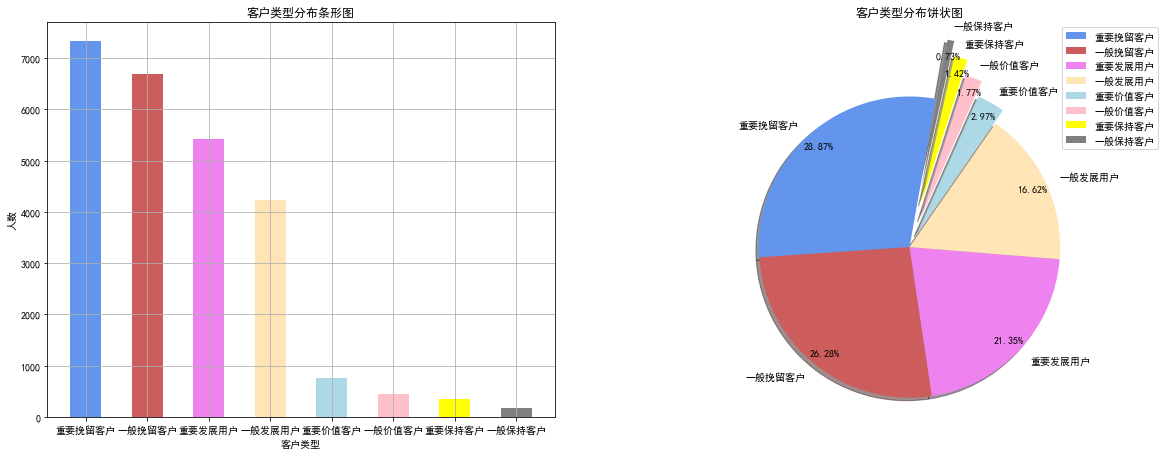

In [85]:
# 数据清洗完毕，进行分组统计，并用饼图表现结果
plt.figure(figsize=(20,16)) #调节图形大小

ax1 = plt.subplot(2,2,1)
x = result['客户类型']
y = result['人数'] 
col = ['cornflowerblue','indianred','violet','moccasin','lightblue','pink','yellow','gray']
# 生产柱状图
plt.bar(x,y,align="center",color=col,width=0.5,alpha=1)
# 设置x，y轴标签
plt.xlabel("客户类型")
plt.ylabel("人数")
plt.title("客户类型分布条形图")
plt.grid()

ax2 = plt.subplot(2,2,2)
labels = result['客户类型']  #定义标签
sizes = result['人数占比'] #每块值
colors = ['cornflowerblue','indianred','violet','moccasin','lightblue','pink','yellow','gray'] #每块颜色定义
explode = (0,0,0,0,0.1,0.2,0.3,0.4) #将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', #数值保留固定小数位
                      shadow = True, #无阴影设置
                      startangle =80, #逆时针起始角度设置
                      pctdistance = 0.9) #数值距圆心半径倍数的距离
#patches饼图的返回值，texts1饼图外label的文本，texts2饼图内部的文本
# x，y轴刻度设置一致，保证饼图为圆形
plt.title('客户类型分布饼状图')
plt.axis('equal')
plt.legend(loc='best')

plt.show()

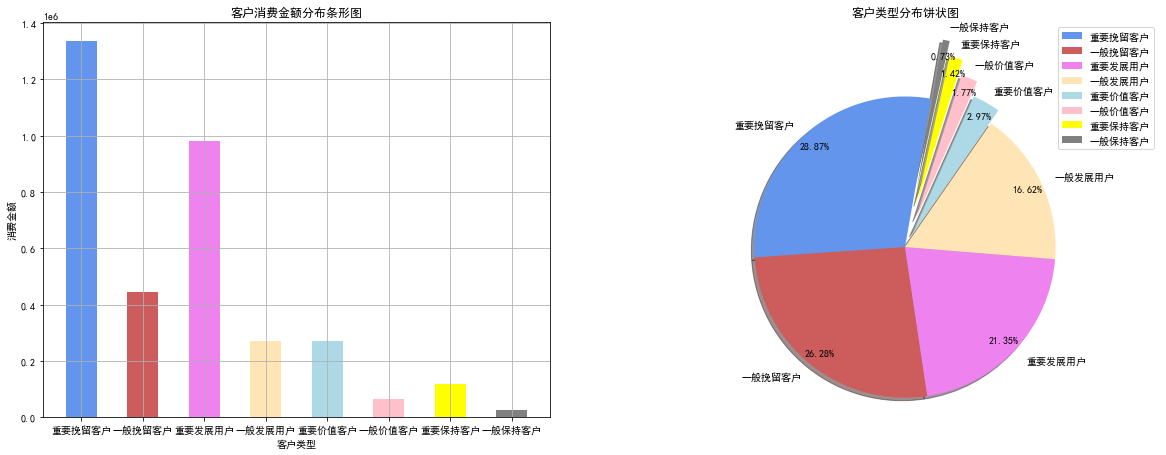

In [86]:
plt.figure(figsize=(20,16)) #调节图形大小
ax3 = plt.subplot(2,2,1)
x = result['客户类型']
y = result['消费金额'] 
col = ['cornflowerblue','indianred','violet','moccasin','lightblue','pink','yellow','gray']
# 生产柱状图
plt.bar(x,y,align="center",color=col,width=0.5,alpha=1)
# 设置x，y轴标签
plt.xlabel("客户类型")
plt.ylabel("消费金额")
plt.title("客户消费金额分布条形图")
plt.grid()
ax4 = plt.subplot(2,2,2)
labels = result['客户类型']  #定义标签
sizes = result['人数占比'] #每块值
colors = ['cornflowerblue','indianred','violet','moccasin','lightblue','pink','yellow','gray'] #每块颜色定义
explode = (0,0,0,0,0.1,0.2,0.3,0.4) #将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', #数值保留固定小数位
                      shadow = True, #无阴影设置
                      startangle =80, #逆时针起始角度设置
                      pctdistance = 0.9) #数值距圆心半径倍数的距离
#patches饼图的返回值，texts1饼图外label的文本，texts2饼图内部的文本
# x，y轴刻度设置一致，保证饼图为圆形
plt.title('客户类型分布饼状图')
plt.axis('equal')
plt.legend(loc='best')
plt.show()

C:\Users\zw\.conda\envs\pytorch_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


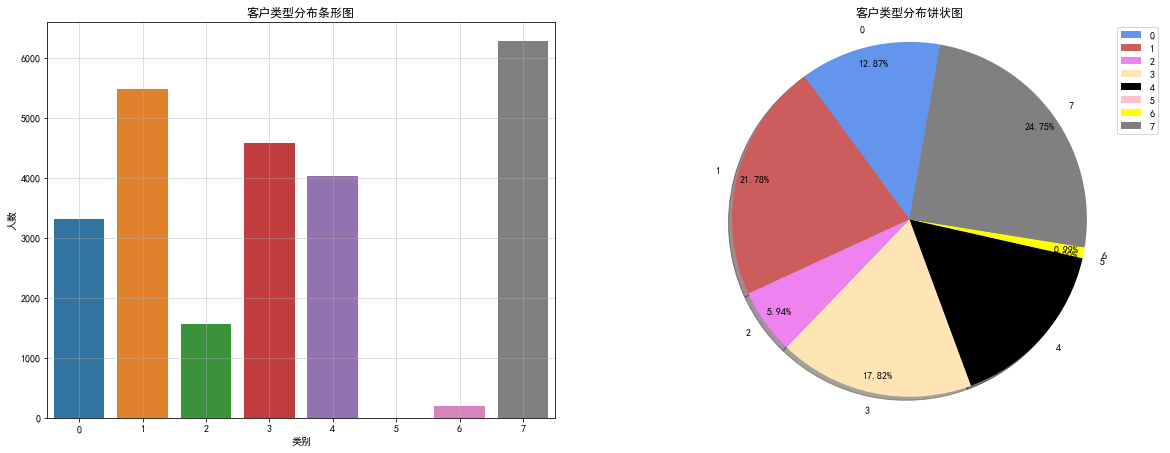

In [87]:
#收纳篮分类
plt.figure(figsize=(20,16))
ax5 = plt.subplot(2,2,1)
cdata_rst
sns.countplot(cdata_rst['类别']) 
plt.ylabel(u"人数")       # 添加y轴标签
plt.title(u"客户类型分布条形图")     # 添加标题
plt.grid(alpha=0.5)      # 设置网格线
ax4 = plt.subplot(2,2,2)
labels = [0,1,2,3,4,5,6,7]  #定义标签
sizes = [ 0.13,0.22,0.06,0.18,0.16,0,0.01,0.25] #每块值
colors = ['cornflowerblue','indianred','violet','moccasin','black','pink','yellow','gray'] #每块颜色定义
explode = (0,0,0,0,0,0,0,0) #将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', #数值保留固定小数位
                      shadow = True, #无阴影设置
                      startangle =80, #逆时针起始角度设置
                      pctdistance = 0.9) #数值距圆心半径倍数的距离
#patches饼图的返回值，texts1饼图外label的文本，texts2饼图内部的文本
# x，y轴刻度设置一致，保证饼图为圆形
plt.title('客户类型分布饼状图')
plt.axis('equal')
plt.legend(loc='best')
plt.show()

In [77]:
cdata_rst['类别'].value_counts()/len(cdata_rst['类别'])

7    0.246932
1    0.215657
3    0.179976
4    0.158301
0    0.130212
2    0.061330
6    0.007553
5    0.000039
Name: 类别, dtype: float64